In [ ]:
#Uninstall conflicting libraries
!pip uninstall -y torch torchaudio torchvision torchdata torchtune thinc numpy
# Install matgl and its dependencies
!pip install matgl

Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
Found existing installation: torchdata 0.8.0
Uninstalling torchdata-0.8.0:
  Successfully uninstalled torchdata-0.8.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached torch-2.4.0-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchdata-0.8.0-cp311-cp311-manylinux1_x86_64.whl.metadata (5.4 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached torch-2.4.0-cp311-cp311-manylinux1_x86_64.whl (797.3 MB)
Using cached torchdata-0.8.0-cp311-cp311-manylinux1_x86_64.whl (2.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

Found existing installation: dgl 2.4.0
Uninstalling dgl-2.4.0:
  Successfully uninstalled dgl-2.4.0
^C


In [1]:
!pip uninstall dgl -y
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html
  Using cached https://data.dgl.ai/wheels/torch-2.4/dgl-2.5.0-cp311-cp311-manylinux1_x86_64.whl (4.8 MB)
Discarding https://data.dgl.ai/wheels/torch-2.4/dgl-2.5.0-cp311-cp311-manylinux1_x86_64.whl (from https://data.dgl.ai/wheels/torch-2.4/repo.html): Requested dgl from https://data.dgl.ai/wheels/torch-2.4/dgl-2.5.0-cp311-cp311-manylinux1_x86_64.whl has inconsistent version: expected '2.5.0', but metadata has '2.5.0+cpu'
  Using cached https://data.dgl.ai/wheels/torch-2.4/dgl-2.4.0-cp311-cp311-manylinux1_x86_64.whl (6.8 MB)


In [4]:
!pip install "numpy<2.0" --upgrade
!pip install mp_api pymatgen ase


  Using cached doped-3.0.0-py3-none-any.whl.metadata (17 kB)
Using cached doped-3.0.0-py3-none-any.whl (358 kB)
  Attempting uninstall: doped
    Found existing installation: doped 3.1.0
    Uninstalling doped-3.1.0:
      Successfully uninstalled doped-3.1.0


In [19]:
!pip uninstall doped
!pip install doped==3.0.0

Found existing installation: doped 3.0.0
Uninstalling doped-3.0.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/doped-3.0.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/doped/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
                       ^^^^^^^^^^

In [2]:
import shutil, os, glob
for p in glob.glob('/content/*'): shutil.rmtree(p) if os.path.isdir(p) else os.remove(p)
print("✅ All files and directories under /content have been deleted.")

✅ All files and directories under /content have been deleted.


In [16]:
import zipfile

zip_path = 'reference.zip'      # path to your ZIP file
extract_to = 'reference/'       # folder where you want files

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_to)

print(f"Extracted all files to: {extract_to}")

Extracted all files to: reference/


In [33]:
#!/usr/bin/env python3
import sys
import json
import shutil
import subprocess
import traceback
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from pymatgen.io.vasp import Poscar
from matgl import load_model
from matgl.ext.ase import Relaxer
from tqdm import tqdm

# --- Utility Functions ---

def read_structure(p: Path) -> Structure:
    """Reads a structure file (CIF, POSCAR/CONTCAR, VASP, XSF) and returns a pymatgen Structure."""
    p = Path(p)
    ext = p.suffix.lower()
    if ext in (".cif", ".vasp") or p.name.upper() in ("POSCAR", "CONTCAR"):
        return Structure.from_file(p)
    if ext == ".xsf":
        # Use atomsk or ase to convert xsf to cif as a temporary step
        tmp_cif = p.with_suffix(".cif")
        try:
            if shutil.which("atomsk"):
                subprocess.run(f"atomsk {p} {tmp_cif}", shell=True, check=True, capture_output=True)
            else:
                from ase.io import read, write
                write(str(tmp_cif), read(p))
            s = Structure.from_file(tmp_cif)
            tmp_cif.unlink()
            return s
        except Exception as e:
            print(f"Error converting {p}: {e}")
            if tmp_cif.exists():
                tmp_cif.unlink()
            sys.exit("Could not convert XSF file. Please install 'atomsk' or 'ase'.")
    # Fallback for other formats pymatgen might support
    return Structure.from_file(p)

def get_central_atom_idx(struct: Structure, symbol: str) -> int:
    """Finds the index of the atom of a given symbol closest to the cell center."""
    center_cart = struct.lattice.get_cartesian_coords([0.5, 0.5, 0.5])
    min_dist, site_idx = float('inf'), -1
    for i, site in enumerate(struct):
        if site.specie.symbol == symbol:
            dist = np.linalg.norm(site.coords - center_cart)
            if dist < min_dist:
                min_dist, site_idx = dist, i
    if site_idx < 0:
        raise ValueError(f"No atom with symbol '{symbol}' found in the structure.")
    return site_idx

def get_min_pbc_distance(struct: Structure, cart_coords: np.ndarray) -> float:
    """Calculates the minimum distance from a point to any atom in the structure, considering PBC."""
    frac_coords = struct.lattice.get_fractional_coords(cart_coords)
    min_dist = float('inf')
    for site in struct:
        fdist = frac_coords - site.frac_coords
        fdist -= np.round(fdist) # Image in same cell
        dist = np.linalg.norm(struct.lattice.get_cartesian_coords(fdist))
        if dist < min_dist:
            min_dist = dist
    return float(min_dist)

def add_interstitial(struct: Structure, symbol: str, min_separation: float = 2.0):
    """Adds an interstitial atom to the structure at a position with maximum separation from other atoms."""
    # Search on a grid for a suitable position
    grid_points = np.linspace(0.3, 0.7, 9)
    best_pos, max_min_dist = None, -1.0
    # Find position that maximizes the minimum distance to any other atom
    for f_coords in product(grid_points, repeat=3):
        cart_coords = struct.lattice.get_cartesian_coords(f_coords)
        min_dist = get_min_pbc_distance(struct, cart_coords)
        if min_dist > max_min_dist:
            max_min_dist, best_pos = min_dist, cart_coords

    if best_pos is not None:
        struct.append(symbol, best_pos, coords_are_cartesian=True)
        return

    raise ValueError(f"Could not find a suitable site for interstitial '{symbol}'.")

def create_defect_structure(bulk_opt: Structure, defect_string: str) -> Structure:
    """Creates a defected structure from the optimized bulk based on a string descriptor."""
    struct = bulk_opt.copy()
    # '+' is used for multiple defects, e.g., V_O+V_Mg
    for part in defect_string.split('+'):
        if part.startswith("V_"):  # Vacancy
            symbol = part[2:]
            idx = get_central_atom_idx(struct, symbol)
            struct.remove_sites([idx])
        elif part.endswith("_i"):  # Interstitial
            symbol = part[:-2]
            add_interstitial(struct, symbol)
        elif '_' in part:  # Substitution
            src_symbol, dst_symbol = part.split('_')
            idx = get_central_atom_idx(struct, src_symbol)
            struct.replace(idx, dst_symbol)
        else:
            raise ValueError(f"Unknown defect type in string: '{part}'")
    return struct

# --- Main Script ---

def main():
    """Main execution function."""
    # --- 1. Setup and User Inputs ---
    print("--- MGL Defect Energy Calculation ---")
    bulk_path_str = input("Enter path to bulk structure file (POSCAR/CIF/XSF): ").strip()
    defect_file_str = input("Enter path to defects list file [default: Defects]: ").strip() or "Defects"

    bulk_path = Path(bulk_path_str)
    defect_file = Path(defect_file_str)

    if not bulk_path.is_file():
        sys.exit(f"ERROR: Bulk structure file not found at '{bulk_path}'")
    if not defect_file.is_file():
        sys.exit(f"ERROR: Defects list file not found at '{defect_file}'")

    # --- 2. Load Models and Define Parameters ---
    # Define paths to pre-trained MGL models for different charge states
    model_base_path = Path("PES")
    charge_dirs = {
        +2: "pbe_p2", +1: "pbe_p1", 0: "pbe_neutral", -1: "pbe_m1", -2: "pbe_m2"
    }

    print("\nLoading MGL models...")
    try:
        relaxers = {
            q: Relaxer(load_model(model_base_path / d), relax_cell=False, optimizer="FIRE")
            for q, d in charge_dirs.items()
        }
        bulk_relaxer = Relaxer(load_model(model_base_path / "pbe_neutral"), relax_cell=True, optimizer="FIRE")
    except Exception as e:
        sys.exit(f"ERROR: Could not load MGL models from '{model_base_path}'. Make sure they exist. Details: {e}")
    print("Models loaded successfully.")

    output_dir = Path("defects")

    # --- 3. Optimize Bulk Structure ---
    print("\n--- Optimizing Bulk Structure ---")
    bulk_initial = read_structure(bulk_path)

    with tqdm(total=1, desc="Bulk Relaxation") as pbar:
        bulk_res = bulk_relaxer.relax(bulk_initial.copy(), fmax=1e-5, steps=50)
        pbar.update(1)

    bulk_opt = bulk_res["final_structure"]
    E_bulk = float(bulk_res["trajectory"].energies[-1])

    a_opt, b_opt, c_opt = bulk_opt.lattice.abc
    print(f"Bulk optimization complete.")
    print(f"  - Final Energy: {E_bulk:.6f} eV")
    print(f"  - Final Lattice (abc): {a_opt:.4f} Å, {b_opt:.4f} Å, {c_opt:.4f} Å")

    # Save optimized bulk structure
    bulk_out_dir = output_dir / "bulk"
    bulk_out_dir.mkdir(parents=True, exist_ok=True)
    Poscar(bulk_opt).write_file(bulk_out_dir / "POSCAR_opt")
    CifWriter(bulk_opt).write_file(bulk_out_dir / "bulk_opt.cif")
    with open(bulk_out_dir / "energy_trajectory.json", "w") as f:
        json.dump([float(e) for e in bulk_res["trajectory"].energies], f, indent=2)
    print(f"Optimized bulk structure saved in '{bulk_out_dir}'")

    # --- 4. Process Defects ---
    with open(defect_file) as f:
        defect_lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]

    results = []

    print(f"\n--- Processing {len(defect_lines)} Defects ---")
    for defect_string in tqdm(defect_lines, desc="Total Defects Progress"):
        # Sanitize defect string to create a valid directory name
        tag = defect_string.replace('+', '_')
        tqdm.write(f"\nProcessing defect: {defect_string} (tag: {tag})")

        try:
            # Create initial defect structure from optimized bulk
            struct_initial_defect = create_defect_structure(bulk_opt, defect_string)
            struct_initial_defect.perturb(0.2) # Perturb to break symmetry
        except ValueError as e:
            tqdm.write(f"  [ERROR] Could not create defect '{defect_string}': {e}")
            row = {"Defect": defect_string, "E_bulk": E_bulk, "Error": str(e)}
            results.append(row)
            continue

        defect_row = {"Defect": defect_string, "E_bulk": E_bulk}

        # Loop over each charge state and relax the structure
        for q, relaxer in tqdm(sorted(relaxers.items()), desc=f"  Charges for {tag}", leave=False):
            charge_dir = output_dir / tag / f"q{q:+d}"
            charge_dir.mkdir(parents=True, exist_ok=True)

            try:
                # Perform relaxation
                res = relaxer.relax(struct_initial_defect.copy(), fmax=1e-5, steps=50)

                # Store results
                final_energy = float(res["trajectory"].energies[-1])
                defect_row[f"E({q:+d})"] = final_energy
                tqdm.write(f"  - Charge {q:+d}: Relaxed Energy = {final_energy:.6f} eV")

                # Save optimized structure and trajectory for this charge state
                final_struct = res["final_structure"]

                # MODIFICATION: The line writing the POSCAR_opt has been removed as requested.
                # Poscar(final_struct).write_file(charge_dir / "POSCAR_opt")

                CifWriter(final_struct).write_file(charge_dir / f"{tag}_q{q:+d}_opt.cif")
                with open(charge_dir / "energy_trajectory.json", "w") as f:
                    json.dump([float(e) for e in res["trajectory"].energies], f, indent=2)

            except Exception:
                tqdm.write(f"  - Charge {q:+d}: [ERROR] Relaxation failed.")
                traceback.print_exc(file=sys.stdout)
                defect_row[f"E({q:+d})"] = "error"

        results.append(defect_row)

    # --- 5. Finalize and Save Summary CSV ---
    print("\n--- Finalizing Results ---")

    charge_cols = [f"E({q:+d})" for q in sorted(charge_dirs, reverse=True)]
    base_cols = ["Defect", "E_bulk"]

    df = pd.DataFrame(results)

    # Ensure all expected columns exist, filling missing with empty strings
    for col in base_cols + charge_cols:
        if col not in df.columns:
            df[col] = ''

    # Reorder columns for clarity and add any extra columns (like 'Error') to the end
    existing_cols = df.columns.tolist()
    final_cols = base_cols.copy()
    for c in charge_cols:
        if c in existing_cols:
            final_cols.append(c)
    for c in existing_cols:
        if c not in final_cols:
            final_cols.append(c)

    df = df[final_cols]

    # Save to CSV
    output_csv = "optimisation_results.csv"
    df.to_csv(output_csv, index=False, float_format="%.6f")
    print(f"\nSummary of results written to '{output_csv}'")

if __name__ == "__main__":
    main()

--- MGL Defect Energy Calculation ---
Enter path to bulk structure file (POSCAR/CIF/XSF): POSCAR
Enter path to defects list file [default: Defects]: Defects

Loading MGL models...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

Models loaded successfully.

--- Optimizing Bulk Structure ---


Bulk Relaxation:   0%|          | 0/1 [00:00<?, ?it/s]Please use atoms.calc = calc
logm result may be inaccurate, approximate err = 7.17116423650302e-13
logm result may be inaccurate, approximate err = 7.11047049437519e-13
logm result may be inaccurate, approximate err = 7.13440189626675e-13
logm result may be inaccurate, approximate err = 7.164004363329745e-13
logm result may be inaccurate, approximate err = 7.198926008405241e-13
logm result may be inaccurate, approximate err = 7.07823538687056e-13
logm result may be inaccurate, approximate err = 7.128813156468407e-13
logm result may be inaccurate, approximate err = 7.195084987889784e-13
logm result may be inaccurate, approximate err = 7.101298193409952e-13
logm result may be inaccurate, approximate err = 7.155306134889132e-13
logm result may be inaccurate, approximate err = 7.19047352542455e-13
logm result may be inaccurate, approximate err = 7.118652584451662e-13
logm result may be inaccurate, approximate err = 7.152000571757305e-13

Bulk optimization complete.
  - Final Energy: -153.403229 eV
  - Final Lattice (abc): 13.2805 Å, 13.2805 Å, 13.2805 Å
Optimized bulk structure saved in 'defects/bulk'

--- Processing 3 Defects ---


Total Defects Progress:   0%|          | 0/3 [00:00<?, ?it/s]


Processing defect: V_Cd (tag: V_Cd)



  Charges for V_Cd:   0%|          | 0/5 [00:00<?, ?it/s]

  Charges for V_Cd:  20%|██        | 1/5 [00:07<00:31,  7.78s/it]

  - Charge -2: Relaxed Energy = -147.940857 eV




  Charges for V_Cd:  40%|████      | 2/5 [00:15<00:22,  7.50s/it]

  - Charge -1: Relaxed Energy = -149.152039 eV




  Charges for V_Cd:  60%|██████    | 3/5 [00:23<00:15,  7.97s/it]

  - Charge +0: Relaxed Energy = -150.637650 eV




  Charges for V_Cd:  80%|████████  | 4/5 [00:30<00:07,  7.35s/it]

  - Charge +1: Relaxed Energy = -151.003189 eV




Total Defects Progress:  33%|███▎      | 1/3 [00:37<01:14, 37.37s/it]

  - Charge +2: Relaxed Energy = -152.018677 eV

Processing defect: V_Te (tag: V_Te)



  Charges for V_Te:   0%|          | 0/5 [00:00<?, ?it/s]

  Charges for V_Te:  20%|██        | 1/5 [00:06<00:25,  6.42s/it]

  - Charge -2: Relaxed Energy = -147.674301 eV




  Charges for V_Te:  40%|████      | 2/5 [00:13<00:21,  7.00s/it]

  - Charge -1: Relaxed Energy = -147.538879 eV




  Charges for V_Te:  60%|██████    | 3/5 [00:20<00:13,  6.89s/it]

  - Charge +0: Relaxed Energy = -150.119888 eV




  Charges for V_Te:  80%|████████  | 4/5 [00:27<00:06,  6.96s/it]

  - Charge +1: Relaxed Energy = -150.687103 eV




Total Defects Progress:  67%|██████▋   | 2/3 [01:12<00:35, 35.84s/it]

  - Charge +2: Relaxed Energy = -152.494217 eV

Processing defect: Cd_i (tag: Cd_i)



  Charges for Cd_i:   0%|          | 0/5 [00:00<?, ?it/s]

  Charges for Cd_i:  20%|██        | 1/5 [00:06<00:26,  6.70s/it]

  - Charge -2: Relaxed Energy = -149.686874 eV




  Charges for Cd_i:  40%|████      | 2/5 [00:14<00:22,  7.50s/it]

  - Charge -1: Relaxed Energy = -149.870056 eV




  Charges for Cd_i:  60%|██████    | 3/5 [00:21<00:14,  7.09s/it]

  - Charge +0: Relaxed Energy = -153.261780 eV




  Charges for Cd_i:  80%|████████  | 4/5 [00:28<00:07,  7.29s/it]

  - Charge +1: Relaxed Energy = -155.875656 eV




Total Defects Progress: 100%|██████████| 3/3 [01:48<00:00, 36.10s/it]

  - Charge +2: Relaxed Energy = -158.345062 eV

--- Finalizing Results ---

Summary of results written to 'optimisation_results.csv'


In [34]:
from pathlib import Path
from doped.chemical_potentials import CompetingPhasesAnalyzer
from monty.serialization import dumpfn
from pymatgen.ext.matproj import MPRester
import pandas as pd

composition = "CdTe"
cpa = CompetingPhasesAnalyzer(composition)

# Collect vasprun.xml files
path = './CompetingPhases'
all_paths = []
for p in Path(path).iterdir():
    if not p.name.startswith('.'):
        pp = p / 'vasprun.xml'
        if pp.is_file():
            all_paths.append(str(pp))  # convert to string for _from_vaspruns()

print("Found vasprun.xml files:", all_paths)

# Load from VASP outputs
cpa._from_vaspruns(all_paths)

# Calculate chemical potentials (returns dict or DataFrame-like)
chempot_results = cpa.calculate_chempots()

# Save to CSV manually
pd.DataFrame(chempot_results).to_csv(f"{composition}_chempots.csv", index=False)
print(f"Saved chemical potentials to {composition}_chempots.csv")

# Connect to Materials Project
API_KEY = "BufWkEdSbFdTyDSR2uHiNW3YTqrUJ73i"
mpr = MPRester(API_KEY)
entries = mpr.get_entries_in_chemsys(["Cd", "Se", "Te"])

# Re-create analyzer from MP entries
cpa = CompetingPhasesAnalyzer(composition, entries=entries)

# Save analyzer object
dumpfn(cpa, f"{composition}_competing_phases.json")

# Optional plot
# cpa.plot_chempot_heatmap()


Parsing vaspruns...: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Found vasprun.xml files: ['CompetingPhases/CdTe/vasprun.xml', 'CompetingPhases/Cd/vasprun.xml', 'CompetingPhases/Te/vasprun.xml']


Parsing vaspruns...: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
Duplicate entry names found for generated competing phases: CdTe_F-43m_EaH_0!


Calculated chemical potential limits (in eV wrt elemental reference phases): 

              Cd       Te
Limit                    
CdTe-Cd  0.00000 -0.72745
CdTe-Te -0.72745  0.00000
Saved chemical potentials to CdTe_chempots.csv


In [35]:
#!/usr/bin/env python3
"""
-----------------------------------------------------------------
CHEMICAL-POTENTIAL TABLE  (native + optional impurities)
-----------------------------------------------------------------
• Reads the Δμ‐table produced by CompetingPhasesAnalyzer
• Adds absolute μ_i = Δμ_i + E_ref(i)
• Generates the list of native defects (+ impurity variants, if requested)
• For every growth condition, evaluates the μ that enters
      V_X   : μ(X)
      X_Y   : μ(Y) − μ(X)
      X_i   : –μ(X)
  and writes the results to  defect_mu_table.csv
-----------------------------------------------------------------
The output format is now "wide":

Defect    , Condition_1, Condition_2, ...
-----------------------------------------
V_Cd      , -1.23      , -1.95      , ...
V_Te      , -4.25      , -3.52      , ...
Cd_Te     ,  3.02      ,  1.56      , ...
...
-----------------------------------------------------------------
"""

import pandas as pd
from pathlib import Path
from pymatgen.io.vasp import Vasprun
from pymatgen.core.composition import Composition

# ---------- STEP 1: user input ----------------------------------------------
compound  = input("Compound formula (e.g. CdTe): ").strip()
csv_file  = input("Δμ CSV file           : ").strip()

add_imp   = input("Consider impurities?  (y/n): ").strip().lower() == "y"
impurities = []
if add_imp:
    impurities = [el.strip() for el in input("Impurity element(s) (e.g. Cl,O): ").split(",")]

# ---------- STEP 2: read Δμ table -------------------------------------------
try:
    Δμ_df = pd.read_csv(csv_file)
    print("\nΔμ table read successfully:\n", Δμ_df)
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found.")
    exit()


# ---------- STEP 3: reference energies --------------------------------------
def E_ref(el):
    """Safely reads reference energy from a vasprun.xml file."""
    filepath = Path(f"CompetingPhases/{el}/vasprun.xml")
    try:
        vr = Vasprun(filepath)
        return vr.final_energy / vr.final_structure.num_sites
    except Exception as e:
        print(f"Error: Could not read or parse {filepath}. Please ensure it exists and is a valid vasprun.xml file.")
        print(f"Details: {e}")
        exit()

elements = [str(el) for el in Composition(compound).elements]
E_ref_dict = {el: E_ref(el) for el in elements + impurities}
print("\n" + "="*30)
for el, E in E_ref_dict.items():
    print(f"E_ref({el}) = {E:.6f} eV/atom")
print("="*30)

# ---------- STEP 4: absolute μ columns --------------------------------------
for el in elements + impurities:
    if el in Δμ_df.columns:
        Δμ_df[f"mu_{el} (eV)"] = Δμ_df[el] + E_ref_dict[el]

# ---------- STEP 5: enumerate defects ---------------------------------------
defects = []
# native
for el in elements:
    defects.append(f"V_{el}")
for el1 in elements:
    for el2 in elements:
        if el1 != el2:
            defects.append(f"{el1}_{el2}")
for el in elements:
    defects.append(f"{el}_i")
# impurities
for imp in impurities:
    defects.append(f"{imp}_i")
    for host in elements:
        defects.append(f"{imp}_{host}")

# Ensure unique defect list in a specific order
defects = sorted(list(set(defects)))
print("\nDefect list:", defects)

# ---------- STEP 6: build and reshape the table -----------------------------
rows = []
for idx, row in Δμ_df.iterrows():
    # Use the 'Limit' column if it exists, otherwise create a generic name
    cond = row.get("Limit", f"Condition_{idx+1}")
    for d in defects:
        parts = d.split("_")
        if d.startswith("V_"):
            el  = parts[1]
            μ   = row.get(f"mu_{el} (eV)", float("nan"))
        elif d.endswith("_i"):
            el  = parts[0]
            μ0  = row.get(f"mu_{el} (eV)", float("nan"))
            μ   = -μ0
        else:   # antisite / impurity substitution
            src, dst = parts   # X_Y means X on Y site, so μ is for Y-X
            μ_src = row.get(f"mu_{src} (eV)", float("nan"))
            μ_dst = row.get(f"mu_{dst} (eV)", float("nan"))
            μ     = μ_dst - μ_src
        rows.append(dict(Condition=cond, Defect=d, mu_eV=μ))

# Create the initial "long" DataFrame
long_df = pd.DataFrame(rows)

# --- MODIFICATION START: Pivot from long to wide format ---
print("\nPivoting table to wide format...")
# Use pivot to reshape the data
# index='Defect' -> each unique defect gets its own row
# columns='Condition' -> each unique condition becomes a column
# values='mu_eV' -> the cells are filled with the chemical potential values
wide_df = long_df.pivot(index='Defect', columns='Condition', values='mu_eV')

# The 'Defect' column is now the index. To make it a regular column, use reset_index()
wide_df = wide_df.reset_index()

# Remove the name of the columns axis ('Condition'), which is good practice after a pivot
wide_df.columns.name = None
# --- MODIFICATION END ---

# Save the new wide DataFrame
wide_df.to_csv("defect_mu_table.csv", index=False, float_format="%.6f")
print("\n✅ defect_mu_table.csv written in WIDE format.")
print(wide_df.head())

Compound formula (e.g. CdTe): CdTe
Δμ CSV file           : CdTe_chempots.csv
Consider impurities?  (y/n): n

Δμ table read successfully:
         Cd       Te
0  0.00000 -0.72745
1 -0.72745  0.00000

E_ref(Cd) = -1.231819 eV/atom
E_ref(Te) = -3.524282 eV/atom

Defect list: ['Cd_Te', 'Cd_i', 'Te_Cd', 'Te_i', 'V_Cd', 'V_Te']

Pivoting table to wide format...

✅ defect_mu_table.csv written in WIDE format.
  Defect  Condition_1  Condition_2
0  Cd_Te    -3.019913    -1.565013
1   Cd_i     1.231819     1.959269
2  Te_Cd     3.019913     1.565013
3   Te_i     4.251732     3.524282
4   V_Cd    -1.231819    -1.959269


--- Defect Formation Energy Diagram Generator ---
✓ Successfully loaded data files.
Enter compound formula for plot title (e.g., CdTe): CdTe
Enter the band gap Eg (eV): 1.5
Enter the Valence Band Maximum VBM (eV): 1.83

--- Select a Growth Condition ---
  1) Condition_1
  2) Condition_2
Enter the number of the condition to use [1-2]: 1
✓ Using condition: Condition_1

--- Select Defects to Plot ---
  1) V_Cd
  2) V_Te
  3) Cd_i
Enter defect names or numbers, separated by commas (e.g., 1,V_Te,3 or all).
Your selection: 3


✓ Selected defects for plotting: Cd_i

--- Calculating Formation Energies ---
✓ Formation energy data written to defect_formations.xlsx
✓ Generating plot...


✓ Diagram saved to CdTe_Condition_1_diagram.png


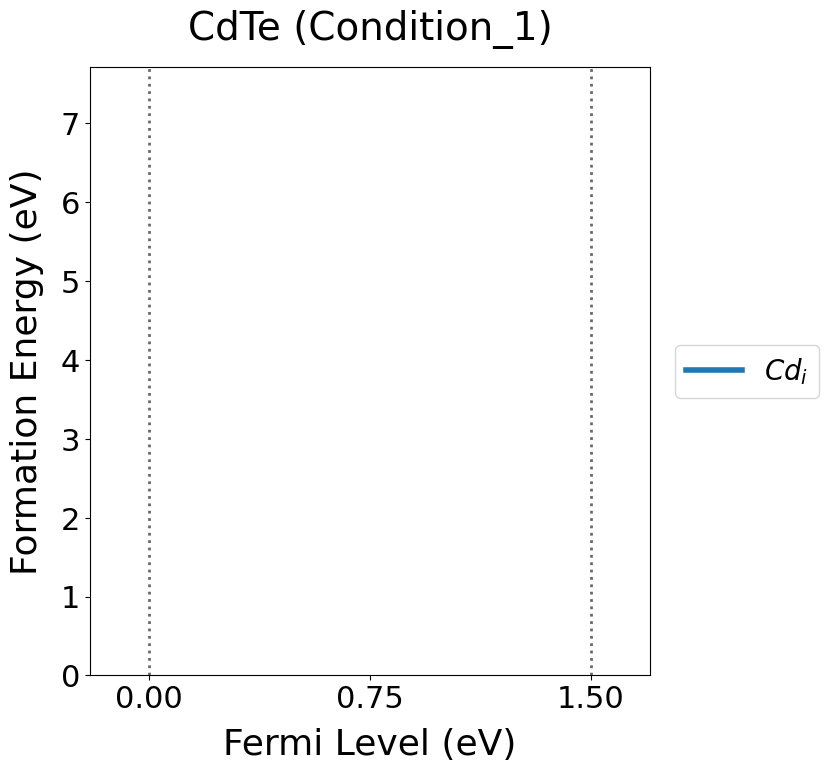

In [40]:
#!/usr/bin/env python3
"""
Formation-energy diagram (minimum-energy envelope)
--------------------------------------------------
Reads the "wide" format CSV files generated by the previous scripts
and interactively prompts the user to select the growth condition
and which defects to plot.

Requires (in current directory):
  optimisation_results.csv      (Wide format: Defect, E_bulk, E(+2), E(+1)...)
  defect_mu_table.csv           (Wide format: Defect, Condition_1, Condition_2...)

Outputs:
  defect_formations.xlsx        Numeric table of formation energies for the selected defects.
  <compound>_<condition>_diagram.png
"""

import sys
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper Functions ---
def parse_charge_from_col(col_name):
    """Extracts integer charge from column names like 'E(+2)' or 'E(-1)'."""
    match = re.search(r'E\(([+-]?\d+)\)', col_name)
    if match:
        return int(match.group(1))
    return None

def format_defect_label(tag):
    """Formats a defect tag string for a Matplotlib plot label with subscripts."""
    if '_' in tag:
        # Split only on the first underscore
        parts = tag.split('_', 1)
        # Use a raw f-string for proper LaTeX-like formatting
        return fr'${parts[0]}_{{{parts[1]}}}$'
    return tag # Return the original tag if no underscore

# --- 1. File and Data Loading ---
print("--- Defect Formation Energy Diagram Generator ---")

# File paths
csv_opt = Path("optimisation_results.csv")
csv_mu = Path("defect_mu_table.csv")

for p in (csv_opt, csv_mu):
    if not p.is_file():
        sys.exit(f"❌ FATAL: Missing required file: {p}")

# Load data into pandas DataFrames
try:
    opt_df = pd.read_csv(csv_opt)
    mu_df = pd.read_csv(csv_mu)
    print("✓ Successfully loaded data files.")
except Exception as e:
    sys.exit(f"❌ FATAL: Could not read CSV files. Error: {e}")

# --- 2. Interactive User Prompts ---

# Basic parameters
compound = input("Enter compound formula for plot title (e.g., CdTe): ").strip()
gap = float(input("Enter the band gap Eg (eV): ").strip())
vbm_val = float(input("Enter the Valence Band Maximum VBM (eV): ").strip())

# Select Growth Condition from mu_table.csv
available_conditions = [c for c in mu_df.columns if c != 'Defect']
if not available_conditions:
    sys.exit("❌ FATAL: No conditions found in defect_mu_table.csv (columns other than 'Defect').")

print("\n--- Select a Growth Condition ---")
for i, cond in enumerate(available_conditions, 1):
    print(f"  {i}) {cond}")
choice = input(f"Enter the number of the condition to use [1-{len(available_conditions)}]: ").strip()
try:
    cond_idx = int(choice) - 1
    if not 0 <= cond_idx < len(available_conditions):
        raise ValueError
    selected_condition = available_conditions[cond_idx]
    print(f"✓ Using condition: {selected_condition}")
except (ValueError, IndexError):
    sys.exit("❌ FATAL: Invalid selection.")

# Robust Defect Selection
available_defects = opt_df['Defect'].tolist()
print("\n--- Select Defects to Plot ---")
for i, defect in enumerate(available_defects, 1):
    print(f"  {i}) {defect}")
print("Enter defect names or numbers, separated by commas (e.g., 1,V_Te,3 or all).")
choice = input("Your selection: ").strip().lower()

selected_defects = []
if choice == 'all':
    selected_defects = available_defects
else:
    defect_lookup = {d.lower(): d for d in available_defects}
    for i, d in enumerate(available_defects, 1):
        defect_lookup[str(i)] = d

    user_inputs = [item.strip() for item in choice.split(',')]
    try:
        for item in user_inputs:
            found_defect = defect_lookup.get(item)
            if found_defect:
                if found_defect not in selected_defects:
                    selected_defects.append(found_defect)
            else:
                raise ValueError(f"Input '{item}' is not a valid defect name or number.")
    except ValueError as e:
        sys.exit(f"❌ FATAL: Invalid selection. {e}")

print(f"✓ Selected defects for plotting: {', '.join(selected_defects)}")


# --- 3. Prepare Data for Plotting ---
E_bulk = opt_df['E_bulk'].iloc[0]
mu_dict = mu_df.set_index('Defect')[selected_condition].to_dict()
charge_cols = {col: parse_charge_from_col(col) for col in opt_df.columns if parse_charge_from_col(col) is not None}

records = []
print("\n--- Calculating Formation Energies ---")
for tag in selected_defects:
    defect_energy_row = opt_df[opt_df['Defect'] == tag]
    if defect_energy_row.empty:
        print(f"⚠️ WARNING: No energy data for '{tag}'. Skipping.")
        continue
    mu_term = mu_dict.get(tag)
    if mu_term is None or pd.isna(mu_term):
        print(f"⚠️ WARNING: No chemical potential for '{tag}'. Skipping.")
        continue
    for col_name, q in charge_cols.items():
        E_defect_q = defect_energy_row[col_name].iloc[0]
        if pd.isna(E_defect_q) or isinstance(E_defect_q, str):
            continue
        E_f0 = E_defect_q - E_bulk - mu_term
        records.append({'Tag': tag, 'q': q, 'E_f0': E_f0})

if not records:
    sys.exit("❌ FATAL: No valid formation energies could be calculated.")

df_f = pd.DataFrame(records)
df_f['Tag'] = pd.Categorical(df_f['Tag'], categories=selected_defects, ordered=True)
df_f = df_f.sort_values('Tag')
df_f.to_excel("defect_formations.xlsx", index=False, float_format="%.6f")
print("✓ Formation energy data written to defect_formations.xlsx")


# --- 4. Plotting ---
print("✓ Generating plot...")
tab_colors = list(plt.cm.tab20.colors)
palette = [tab_colors[i] for i in [0, 2, 4, 6, 8, 10, 12, 14, 1, 3, 5, 7, 9, 11, 13, 15]]

EF = np.arange(-0.5, gap + 0.5, 0.01)
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=0.14, bottom=0.14, right=0.70, top=0.90)
# MODIFICATION: Removed hardcoded font family to prevent warnings
plt.title(f"{compound} ({selected_condition})", fontsize=28, pad=20)

for i, tag in enumerate(selected_defects):
    sub_df = df_f[df_f.Tag == tag]
    if sub_df.empty:
        continue
    all_energies = [row.E_f0 + row.q * (EF + vbm_val) for _, row in sub_df.iterrows()]
    E_envelope = np.min(all_energies, axis=0)
    style = 'solid' if (i % 2 == 0) else 'dashed'
    color = palette[i % len(palette)]
    # MODIFICATION: Use the new helper function for correct labels
    plt.plot(EF, E_envelope, lw=4, ls=style, c=color, label=format_defect_label(tag))

plt.axvline(0, color='dimgrey', linestyle=':', lw=2)
plt.axvline(gap, color='dimgrey', linestyle=':', lw=2)
plt.xlabel("Fermi Level (eV)", size=26, labelpad=10)
plt.ylabel("Formation Energy (eV)", size=26, labelpad=12)
plt.xlim(-0.2, gap + 0.2)
plt.ylim(0, max(6.5, df_f['E_f0'].max() + 1 if not df_f.empty else 6.5))
plt.xticks([0, round(gap / 2, 2), round(gap, 2)], fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, prop={'size': 20})

out_png = f"{compound}_{selected_condition}_diagram.png".replace(" ", "_")
plt.savefig(out_png, dpi=300, bbox_inches='tight')
print(f"✓ Diagram saved to {out_png}")
plt.show()

\